## Feature engineering

El objetivo de este notebook es generar nuevas variables a partir de las analizadas. Tambíen se hará una breve exploración para determinar si son variables que pueden ser importantes para el modelo.

### Import de los paquetes

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Configuraciones

In [2]:
np.random.seed(42)

In [3]:
pd.set_option("display.max_columns", None)

### Funciones auxiliares

#### Graficos

In [4]:
def plot_confusion_matrix(cm: np.ndarray, classes: list, ax=None):
    """
    Grafica una matriz de confusión.

    Args:
        cm (np.ndarray): La matriz de confusión.
        classes (list): Las etiquetas de clase.
        ax: El objeto de eje para dibujar el gráfico (por defecto: None).

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()  # Obtener el eje actual si no se proporciona uno

    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title("Matriz de Confusión")
    plt.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        ax.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    ax.set_ylabel("Etiqueta Real")
    ax.set_xlabel("Etiqueta Predicha")

In [5]:
def plot_roc_curve(y_test: np.ndarray, y_proba: np.ndarray, ax=None):
    """
    Grafica la curva ROC.

    Args:
        y_test (np.ndarray): Las etiquetas reales.
        y_proba (np.ndarray): Las probabilidades predichas.
        ax: El objeto de eje para dibujar el gráfico (por defecto: None).

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()  # Obtiene el eje actual si no se proporciona uno

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    ax.plot(fpr, tpr, label="Curva ROC (AUC = %0.2f)" % roc_auc)
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("Tasa de Falsos Positivos")
    ax.set_ylabel("Tasa de Verdaderos Positivos")
    ax.set_title("Curva ROC")
    ax.legend(loc="lower right")

#### Generación de métricas

In [6]:
def track_metrics(
    pipeline,
    x: np.ndarray,
    y: np.ndarray,
    set_name: str = "test",
    threshold: float = 0.5,
):
    """
    Registra métricas para un pipeline de clasificación.

    Args:
        pipeline: El pipeline de clasificación.
        x (np.ndarray): Las características de entrada.
        y (np.ndarray): Las etiquetas reales.
        set_name (str): El nombre del conjunto de datos (por defecto: "test").
        threshold (float): El umbral de predicción (por defecto: 0.5).

    Returns:
        None
    """
    # Predecir probabilidades
    y_proba = pipeline.predict_proba(x)[:, 1]

    # Aplicar el umbral
    y_pred = (y_proba >= threshold).astype(int)

    # Calcular la precisión
    accuracy = accuracy_score(y, y_pred)

    # Calcular métricas
    cm = confusion_matrix(y, y_pred)

    # Imprimir el informe de clasificación
    report = classification_report(y, y_pred, target_names=["Negativo", "Positivo"])
    print(f"Informe de Clasificación:\n{report}")

    # Calcular precision, recall, f1-score y support para cada clase utilizando output_dict
    metrics_dict = precision_recall_fscore_support(
        y, y_pred, average=None, labels=[0, 1]
    )

    # Crear una figura con dos subgráficos en la misma fila
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Graficar la matriz de confusión en el primer subgráfico
    plot_confusion_matrix(cm, classes=["Negativo", "Positivo"], ax=axes[0])
    axes[0].set_title("Matriz de Confusión")

    # Graficar la curva ROC en el segundo subgráfico
    plot_roc_curve(y, y_proba, ax=axes[1])
    axes[1].set_title("Curva ROC")
    plt.show()

    # Devolver métricas como un diccionario
    metrics = {
        f"{set_name}_Precisión (Negativo)": round(metrics_dict[0][0], 2),
        f"{set_name}_Precisión (Positivo)": round(metrics_dict[0][1], 2),
        f"{set_name}_Recall (Negativo)": round(metrics_dict[1][0], 2),
        f"{set_name}_Recall (Positivo)": round(metrics_dict[1][1], 2),
        f"{set_name}_F1-Score (Negativo)": round(metrics_dict[2][0], 2),
        f"{set_name}_F1-Score (Positivo)": round(metrics_dict[2][1], 2),
        f"{set_name}_Exactitud": round(accuracy, 2),
    }

    return metrics

In [7]:
def save_metrics_to_csv(
    metrics_test: dict, metrics_val: dict, params: dict, model_name: str
) -> None:
    """
    Agrega las métricas de un experimento a un archivo CSV existente o crea uno nuevo.

    Parameters:
        metrics_test (dict): Métricas del conjunto de prueba.
        metrics_val (dict): Métricas del conjunto de validación.
        params (dict): Parámetros del modelo y del experimento.
        model_name (str): Nombre del modelo.

    Returns:
        None
    """
    # Obtén el timestamp actual como parte del nombre del archivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Definir el nombre del archivo CSV con el timestamp
    csv_filename = "../metrics/experiments.csv"

    try:
        # Intenta cargar el archivo CSV existente
        df_existing = pd.read_csv(csv_filename)

    except FileNotFoundError:
        # Si el archivo no existe, crea un DataFrame vacío
        df_existing = pd.DataFrame()

    # Crea DataFrames de pandas con las métricas de test y validación
    df_test = pd.DataFrame([metrics_test])
    df_val = pd.DataFrame([metrics_val])
    df_params = pd.DataFrame([params])

    # Combina los DataFrames en uno solo
    df_combined = pd.concat([df_params, df_test, df_val], axis=1)

    # Agrega columnas adicionales para timestamp y nombre del modelo
    df_combined["run_timestamp"] = timestamp
    df_combined["model"] = model_name

    # Combina el DataFrame existente con los DataFrames de test y validación
    df_existing = pd.concat([df_existing, df_combined], axis=0)

    # Guarda el DataFrame actualizado como un archivo CSV
    df_existing.to_csv(csv_filename, index=False)
    print(f"Métricas agregadas y guardadas en {csv_filename}")

### Carga de datos

In [8]:
df = pd.read_csv("../data/processed/dataset_training_v0.csv")
df.shape

(2962, 18)

In [9]:
df.head()

,invoiceId,businessId,payerId,relationDays,relationRecurrence,issuerCancelledInvoices,diasActividadPagador,facturaMorosa,montoFacturaWsz,issuerInvoicesAmountWsz,Clients12MonthsWsz,payerAmountFacturas,payerRatioMorosidad,payerAvgAmountFacturas,payerAvgDiasMora,payerDesvAmount,businessRatioMororsidad,businessAvgDiasMora
0,11654,5,5015,428.0,10.166667,0.021942,2632.0,1,4713103.0,187036960.0,4.0,181609529.0,0.400000,4035767,2.266667,677336.0,0.000000,0.000000
1,13430,5,5015,455.0,9.891304,0.020079,2659.0,0,7879645.0,231623853.0,4.0,210861531.0,0.423077,4055029,2.865385,3824616.0,1.000000,18.000000
2,15957,5,5015,493.0,9.264151,0.016629,2697.0,1,1190417.0,272695026.0,4.0,261505599.0,0.348485,3962206,6.348485,-2771789.0,0.500000,6.000000
3,18135,5,5015,542.0,9.016667,0.014322,2746.0,0,189924.0,321318559.0,3.0,278112178.0,0.375000,3862669,7.041667,-3672745.0,0.666667,4.333333
4,19438,5,5015,562.0,8.920635,0.013314,2766.0,0,3755846.0,346234215.0,3.0,297456818.0,0.376623,3863075,6.181818,-107229.0,0.500000,3.250000


### Split del conjunto de entrenamiento

La lógica utilizada será la siguiente. Para evitar sacar conclusiones incorrectas por causa del overfitting, utilizaremos la siguiente estrategia:
- Dado que contamos con pocos datos, utilizaremos un **80%** de los mismos para entrenar el modelo.
- Un **10%** irá a testing, con el motivo de generar ese entrenamiento.
- Otro **10%** irá a validación. Dado que este set tiene que ser uno nunca antes visto por el modelo utilizaremos el 10% de las últimas facturas emitidas.

In [10]:
# Ordenamos los datos
df = df.sort_values("invoiceId").copy()
df.drop(columns=["invoiceId", "businessId", "payerId"], inplace=True)

# Especificar las características (X) y el objetivo (y)
x = df.drop(columns=["facturaMorosa"], axis=1)
y = df["facturaMorosa"]

# Obtener las últimas 150 filas para validación
x_val = x.iloc[-250:]
y_val = y.iloc[-250:]

# Eliminar las últimas 150 filas de x e y
x = x.iloc[:-250]
y = y.iloc[:-250]

# Dividir el conjunto en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=15
)


# Verificamos las formas de los conjuntos resultantes
print("Formas de los conjuntos:")
print("Entrenamiento:", x_train.shape, y_train.shape)
print("Prueba:", x_test.shape, y_test.shape)
print("Validación:", x_val.shape, y_val.shape)


# Mostrar las formas de las particiones
print("Forma de x_train:", x_train.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Formas de los conjuntos:
Entrenamiento: (2440, 14) (2440,)
Prueba: (272, 14) (272,)
Validación: (250, 14) (250,)
Forma de x_train: (2440, 14)
Forma de x_val: (250, 14)
Forma de x_test: (272, 14)
Forma de y_train: (2440,)
Forma de y_val: (250,)
Forma de y_test: (272,)


In [11]:
# Creamos un diccionario donde guardamos todo el conjunto de datos
datasets = {
    "train": (x_train, y_train),
    "test": (x_test, y_test),
    "val": (x_val, y_val),
}

### Evaluamos distintos modelos

#### Funciones auxiliares

In [12]:
def run_experiments(
    models: list, datasets: dict, run_params: dict = None, save_csv: bool = True
):
    """
    Runs experiments for multiple models.

    Args:
        models (list): A list of tuples containing the model class and model parameters.
        datasets (dict): A dictionary containing the datasets for training, testing, and validation.
        run_params (dict): Additional parameters for the experiment runs (default: None).
        save_csv (bool): Whether to save metrics to CSV files (default: False).

    Returns:
        None
    """
    x_train, y_train = datasets["train"]
    x_test, y_test = datasets["test"]
    x_val, y_val = datasets["val"]

    for model in models:
        # Initialize the run
        model_name = model.__name__
        print("=" * 130)
        print(f"Starting experiment for model: {model_name}.")
        print("=" * 130)

        try:
            steps = [("scaler", StandardScaler()), ("model", model())]
            pipeline = Pipeline(steps=steps)

            # Entrenamiento del modelo
            pipeline.fit(x_train, y_train)

            # Tracking de métricas
            print("=" * 130)
            print("METRICAS EN TESTING SET")
            print("=" * 130)
            metrics_test = track_metrics(
                pipeline,
                x_test,
                y_test,
                set_name="test",
                threshold=run_params["threshold"],
            )

            # Tracking de métricas
            print("=" * 130)
            print("METRICAS EN VALIDATION SET")
            print("=" * 130)
            metrics_val = track_metrics(
                pipeline,
                x_val,
                y_val,
                set_name="val",
                threshold=run_params["threshold"],
            )

            if save_csv:
                # Guardar métricas en CSV
                save_metrics_to_csv(metrics_test, metrics_val, run_params, model_name)

        except Exception as e:
            print(e)

        finally:
            print("Experimento completado.")

#### Configuración de los experimentos

In [13]:
# Para remover el sampleo remplazar los string con None
params = {
    "threshold": 0.5,
}

In [14]:
models = [
    DecisionTreeClassifier,
    XGBClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
]

Starting experiment for model: DecisionTreeClassifier.
METRICAS EN TESTING SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.72      0.66      0.69       172
    Positivo       0.49      0.56      0.52       100

    accuracy                           0.62       272
   macro avg       0.61      0.61      0.61       272
weighted avg       0.64      0.62      0.63       272



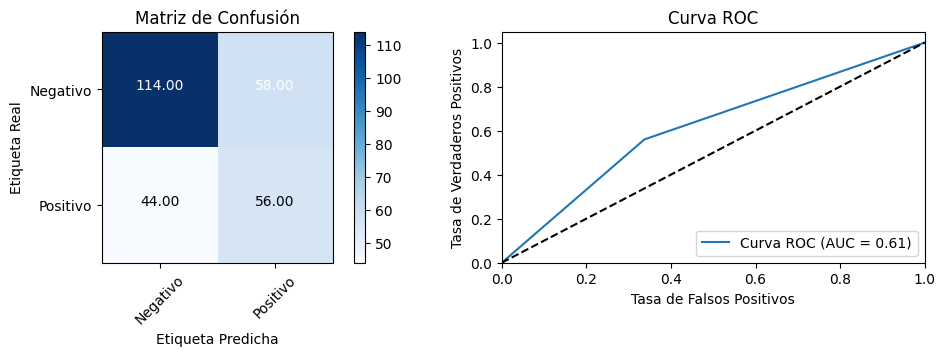

METRICAS EN VALIDATION SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.75      0.74      0.75       177
    Positivo       0.39      0.41      0.40        73

    accuracy                           0.64       250
   macro avg       0.57      0.58      0.57       250
weighted avg       0.65      0.64      0.65       250



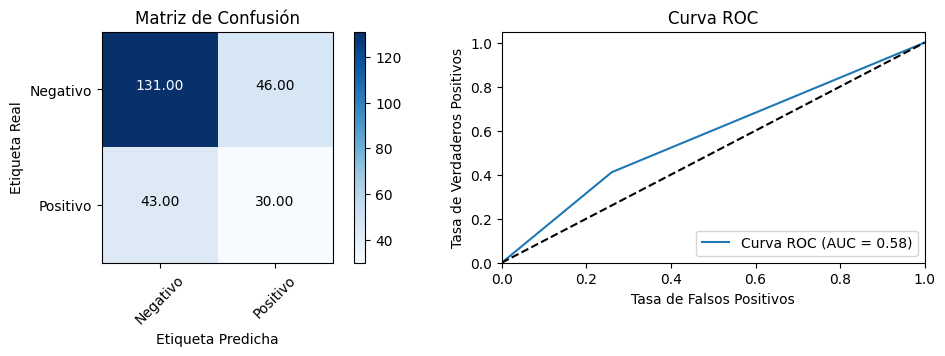

Métricas agregadas y guardadas en ../metrics/experiments.csv
Experimento completado.
Starting experiment for model: XGBClassifier.
METRICAS EN TESTING SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.73      0.75      0.74       172
    Positivo       0.55      0.53      0.54       100

    accuracy                           0.67       272
   macro avg       0.64      0.64      0.64       272
weighted avg       0.67      0.67      0.67       272



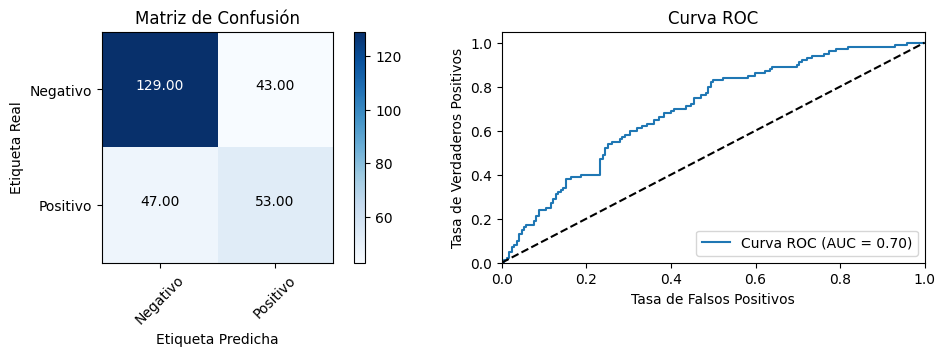

METRICAS EN VALIDATION SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.76      0.79      0.77       177
    Positivo       0.44      0.41      0.43        73

    accuracy                           0.68       250
   macro avg       0.60      0.60      0.60       250
weighted avg       0.67      0.68      0.67       250



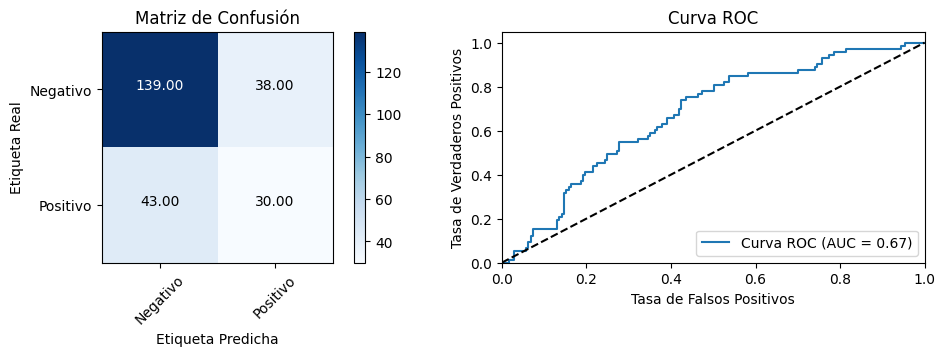

Métricas agregadas y guardadas en ../metrics/experiments.csv
Experimento completado.
Starting experiment for model: RandomForestClassifier.
METRICAS EN TESTING SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.77      0.74      0.75       172
    Positivo       0.58      0.61      0.59       100

    accuracy                           0.69       272
   macro avg       0.67      0.67      0.67       272
weighted avg       0.70      0.69      0.69       272



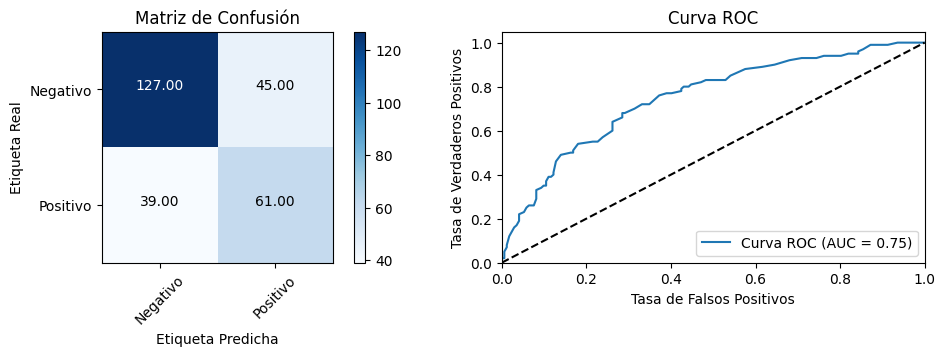

METRICAS EN VALIDATION SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.78      0.80      0.79       177
    Positivo       0.49      0.47      0.48        73

    accuracy                           0.70       250
   macro avg       0.64      0.63      0.64       250
weighted avg       0.70      0.70      0.70       250



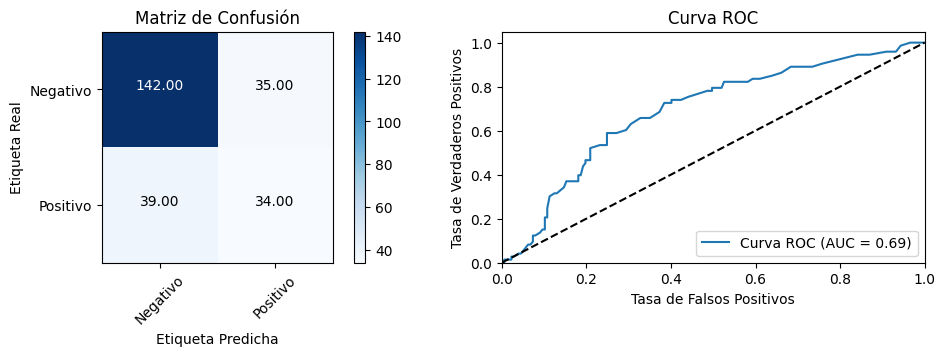

Métricas agregadas y guardadas en ../metrics/experiments.csv
Experimento completado.
Starting experiment for model: GradientBoostingClassifier.
METRICAS EN TESTING SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.76      0.76      0.76       172
    Positivo       0.59      0.60      0.59       100

    accuracy                           0.70       272
   macro avg       0.68      0.68      0.68       272
weighted avg       0.70      0.70      0.70       272



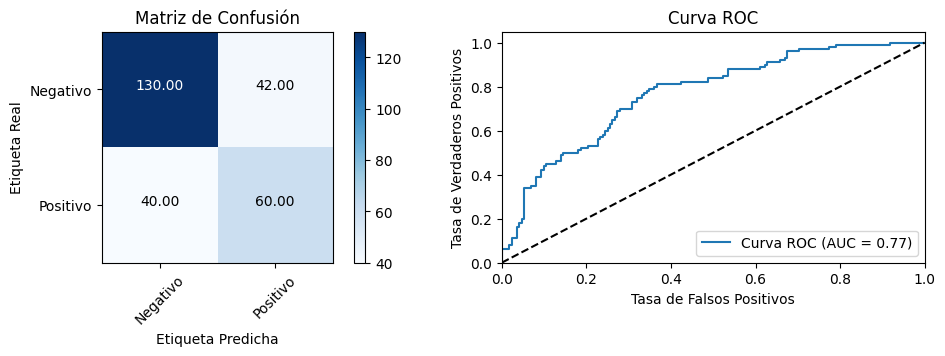

METRICAS EN VALIDATION SET
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.78      0.82      0.80       177
    Positivo       0.52      0.45      0.48        73

    accuracy                           0.72       250
   macro avg       0.65      0.64      0.64       250
weighted avg       0.71      0.72      0.71       250



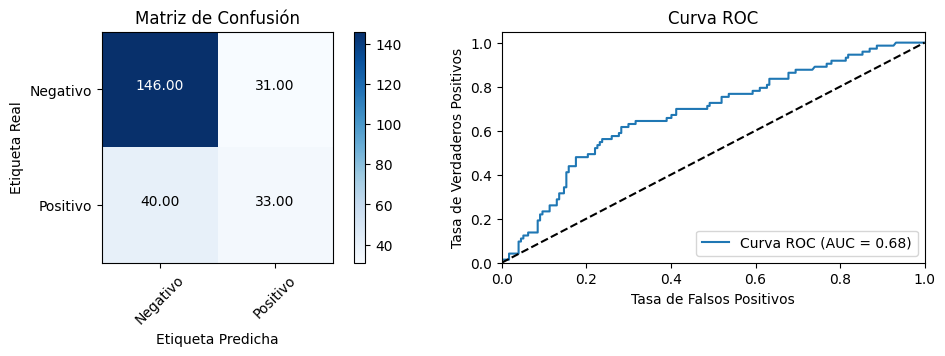

Métricas agregadas y guardadas en ../metrics/experiments.csv
Experimento completado.


In [15]:
run_experiments(models, datasets, params)